In [1]:
%matplotlib inline

In [2]:
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn
import sklearn.linear_model
from datetime import datetime, date
import warnings
import timeit
from collections import defaultdict, OrderedDict
import time
from IPython.display import display
import scipy
from scipy import stats
import pystan

timeit.template = """
def inner(_it, _timer{init}):
    {setup}
    _t0 = _timer()
    for _i in _it:
        retval = {stmt}
    _t1 = _timer()
    return _t1 - _t0, retval
"""

matplotlib.style.use('ggplot')

RANDOM_SEED = 33

## Load and clean the data

In [3]:
DATE_FORMAT = r'%d/%m/%Y'

mauna_loa = pandas.read_csv(r'./weekly_in_situ_co2_mlo_data_only.csv')
first_day = datetime.strptime(mauna_loa['ds'][0], r'%d/%m/%Y')
mauna_loa['day'] = [(datetime.strptime(date_string, DATE_FORMAT) - first_day).days
                    for date_string in mauna_loa['ds']]

day_range = max(mauna_loa['day']) - min(mauna_loa['day'])
mauna_loa['norm_day'] = mauna_loa['day'] / day_range

y_min = min(mauna_loa['y'])
y_range = max(mauna_loa['y']) - y_min
mauna_loa['norm_y'] = (mauna_loa['y'] - y_min)/ y_range

mauna_loa.head()

,ds,y,day,norm_day,norm_y
0,29/03/1958,316.19,0,0.000000,0.032427
1,05/04/1958,317.31,7,0.000322,0.043957
2,12/04/1958,317.69,14,0.000643,0.047869
3,19/04/1958,317.58,21,0.000965,0.046737
4,26/04/1958,316.48,28,0.001286,0.035413


In [4]:
mauna_loa.to_csv('./cleaned_mauna_loa_data.csv')

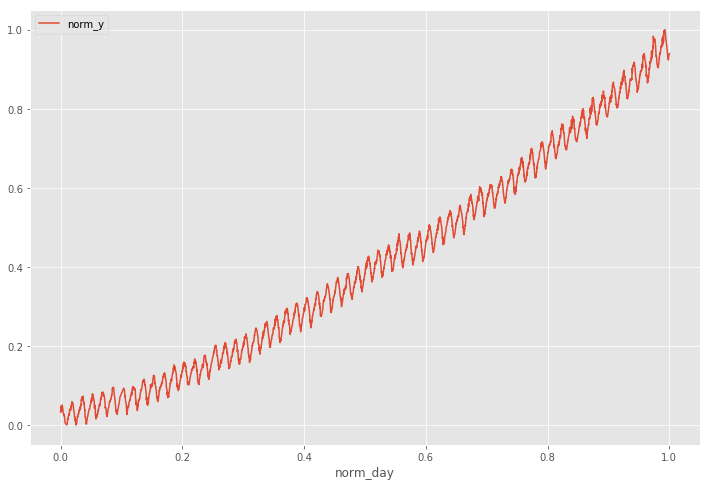

In [5]:
mauna_loa.plot(x='norm_day', y='norm_y', figsize=(12, 8))

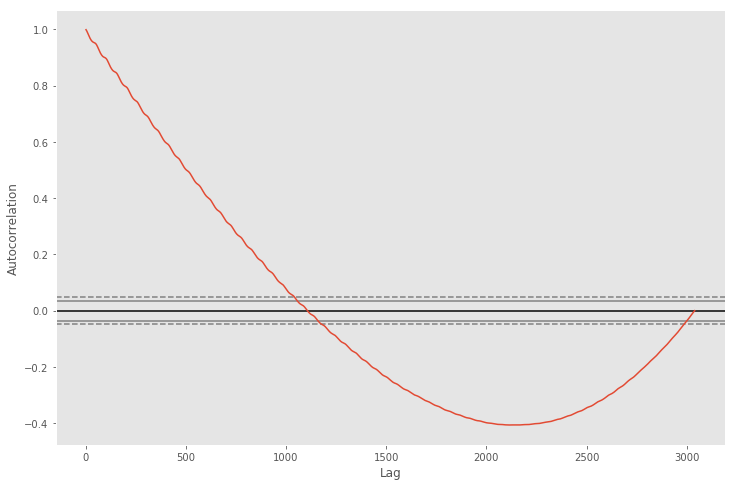

In [6]:
from pandas.plotting import autocorrelation_plot, lag_plot

fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
autocorrelation_plot(mauna_loa['norm_y'], ax)

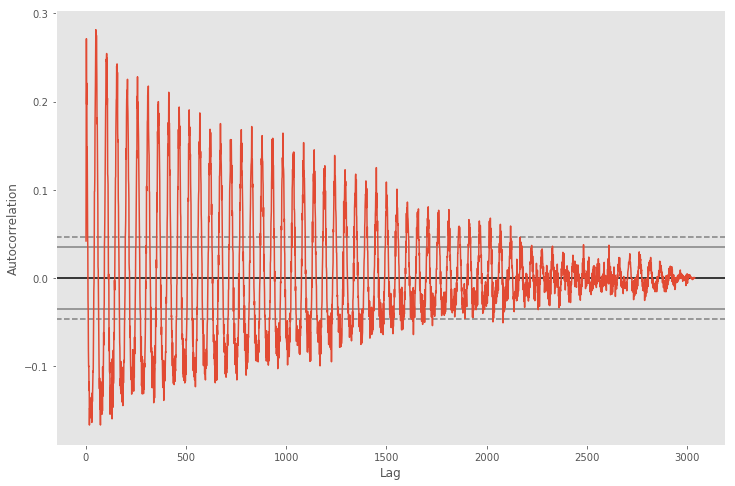

In [7]:
y_diffs = [y - x for x, y in zip(mauna_loa['norm_y'], mauna_loa['norm_y'][1:])] 
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
autocorrelation_plot(y_diffs, ax)

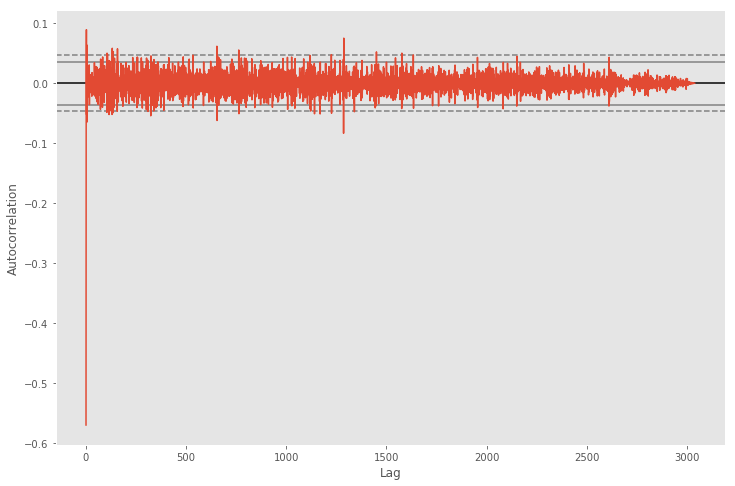

In [8]:
second_diffs = [y - x for x, y in zip(y_diffs, y_diffs[1:])] 
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
autocorrelation_plot(second_diffs, ax)

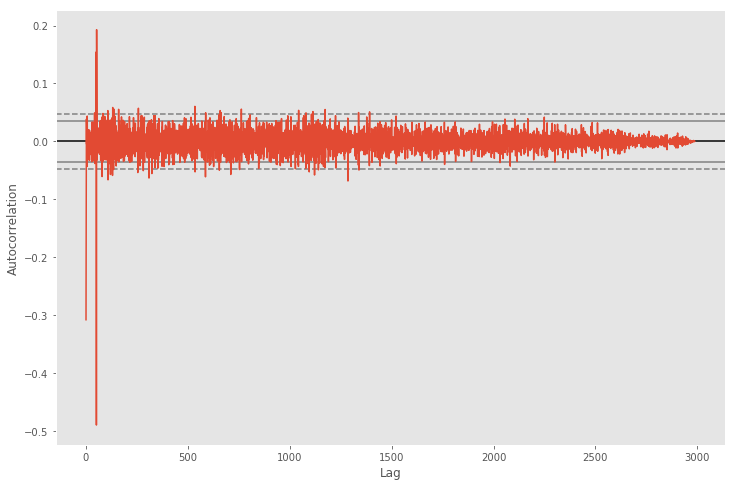

In [9]:
t_diffs = [y - x for x, y in zip(y_diffs, y_diffs[52:])] 
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
autocorrelation_plot(t_diffs, ax)

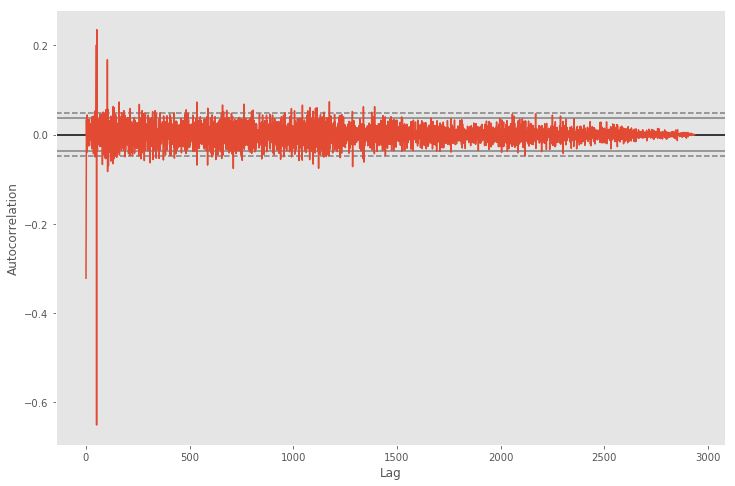

In [10]:
t2_diffs = [y - x for x, y in zip(t_diffs, t_diffs[52:])] 
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
autocorrelation_plot(t2_diffs, ax)

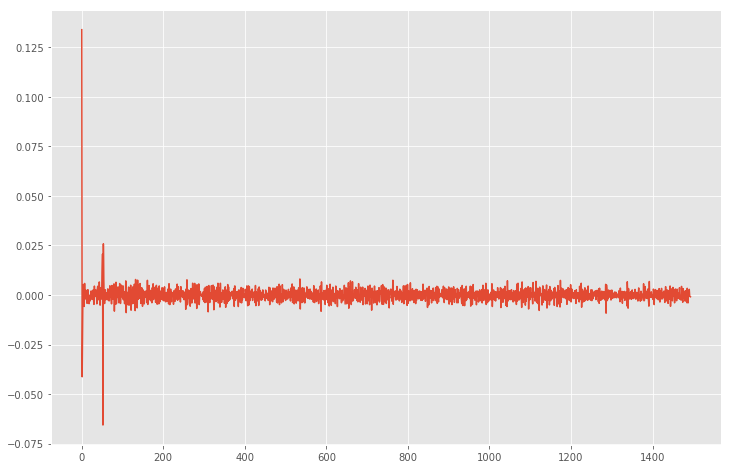

In [11]:
corr = np.correlate(t_diffs, t_diffs, 'same')
half_corr = corr[corr.shape[0] // 2:]
fig = plt.figure(figsize=(12, 8))
plt.plot(half_corr)

In [12]:
np.argmax(half_corr[1:])

52

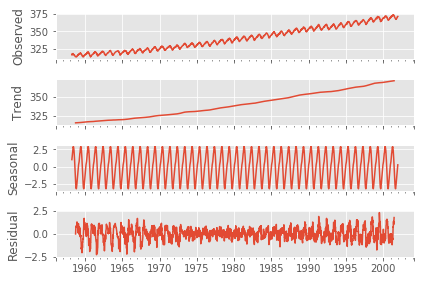

In [23]:
import statsmodels.api as sm

dta = sm.datasets.co2.load_pandas().data
# deal with missing values. see issue
dta.co2.interpolate(inplace=True)

res = sm.tsa.seasonal_decompose(dta.co2)

fig = plt.figure(figsize=(12, 8))
resplot = res.plot()

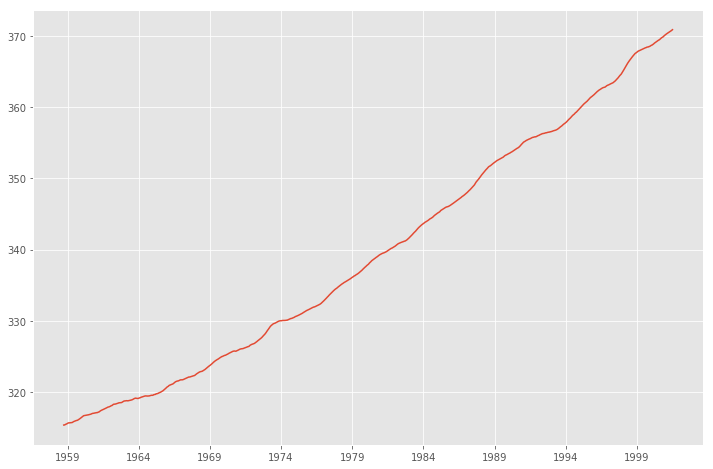

In [29]:
fig = plt.figure(figsize=(12, 8))
plt.plot(res.trend)

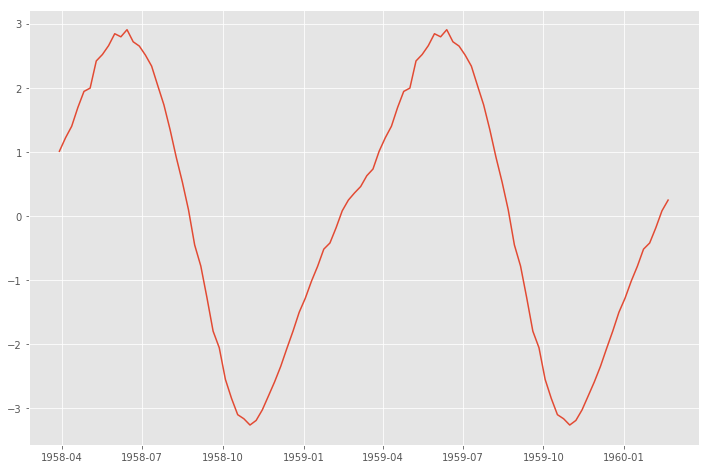

In [31]:
fig = plt.figure(figsize=(12, 8))
plt.plot(res.seasonal[:100])

## Start with a very naive Stan model 

In [ ]:
local_linear_model = """
data {
    int<lower=0> N; // number of data points
    int<lower=0> N_future; // number of 'future' test set data points
    vector[N] y;      // observed CO2 values
    vector[N] t;      // the days 
}

parameters {
    real alpha;    // linear regression intercept
    real beta;     // linear regression slope
    real<lower=0> sigma_lr; // linear regression slope
    real<lower=0, upper=1> rho;      // local trend learning rate

    real delta[N];               // slope at time t    
    real<lower=0> sigma_mu;      // standard deviation of the observation noise 
    real<lower=0> sigma_delta;   // standard deviation of the observation noise 
    
    // real mu;
    // real<lower=0> tau;
    
}
/*
transformed parameters {
    
    
    for (j in 1:J)
    theta[j] = mu + tau * eta[j];
}
*/

model {
    alpha ~ normal(0, 0.1);
    beta ~ normal(0, 0.1);
    sigma_lr ~ gamma(1, 0.1);
    rho ~ normal(0.1, 0.03);
    
    y ~ normal(alpha + t * beta, sigma_lr);

    sigma_delta ~ gamma(1, 0.1);
    sigma_mu ~ gamma(1, 0.1);

    delta[1] ~ normal(y[1], sigma_delta);
    y[1] ~ normal(delta[1], sigma_mu);
    
    for (i in 2:N) {
        delta[i] ~ normal(beta + rho * (delta[i - 1] - beta), sigma_delta);
        y[i] ~ normal(y[i - 1] + delta[i], sigma_mu);
    }
}

generated quantities {
  real delta_future[N_future];
  real y_future[N_future];
  
  delta_future[1] = normal_rng(delta[N], sigma_delta);
  y_future[1] = normal_rng(delta_future[1], sigma_mu);
  
  for(i in 2:N_future) {
    delta_future[i] = normal_rng(beta + rho * (delta_future[i - 1] - beta), sigma_delta);
    y_future[i] = normal_rng(y_future[i - 1] + delta_future[i], sigma_mu);
  }
}
"""

llm = pystan.StanModel(model_code=local_linear_model, model_name='local_linear', verbose=True)

In [ ]:
local_linear_data = {
    'N': len(train),
    'N_future': len(test),
    'y': train['norm_y'],
    't': train['norm_day'],
}

fit = llm.sampling(data=local_linear_data, iter=1000, chains=2, n_jobs=2, 
                  init=lambda: {'sigma_delta': 0.05, 'sigma_mu': 0.05, 'sigma_lr': 0.05, 'rho': 0.1,
                               'alpha': 0, 'beta': 0.1}
                  )

fit

In [ ]:
samples = fit.extract()

In [ ]:
def plot_samples(samples, future=100):
    delta_means = np.mean(samples['delta'], axis=0)
    delta_stds = np.std(samples['delta'], axis=0)
    noise = delta_stds + np.mean(samples['sigma_delta']) + np.mean(samples['sigma_mu'])
    y = [delta_means[0]]
    for d in delta_means[1:]:
        y.append(y[-1] + d)
        
    y = np.asarray(y)
        
    ax = mauna_loa.plot(x='norm_day', y='norm_y', figsize=(12, 8), color='black')
    ax.plot(train['norm_day'], y, color='red')
    ax.fill_between(train['norm_day'], y - 2 * noise, y + 2 * noise, alpha=0.4, 
                          facecolor='red')
    
    y_future_means = np.mean(samples['y_future'], axis=0)
    y_future_stds = np.std(samples['y_future'], axis=0)
    
    ax.plot(test['norm_day'][:future], y_future_means[:future], color='blue')
    ax.fill_between(test['norm_day'][:future], y_future_means[:future] - 2 * y_future_stds[:future], 
                    y_future_means[:future] + 2 * y_future_stds[:future], alpha=0.4, facecolor='blue')
    
    plt.show()

plot_samples(samples)

## This does not look promising. In the mean time, let's go for a different model

TODO:
* Set initial frequency from periodgram
* Set initial amplitude from detrended data
* Consider setting local slope as an MA rather than linear regression

In [56]:
TRAIN_SIZE = 1040
TEST_SIZE = 1040
train = mauna_loa[:TRAIN_SIZE]
test = mauna_loa[TRAIN_SIZE:TRAIN_SIZE + TEST_SIZE]

# TEST_SIZE = 52 * 8
# train = mauna_loa[:-TEST_SIZE]
# test = mauna_loa[-TEST_SIZE:]

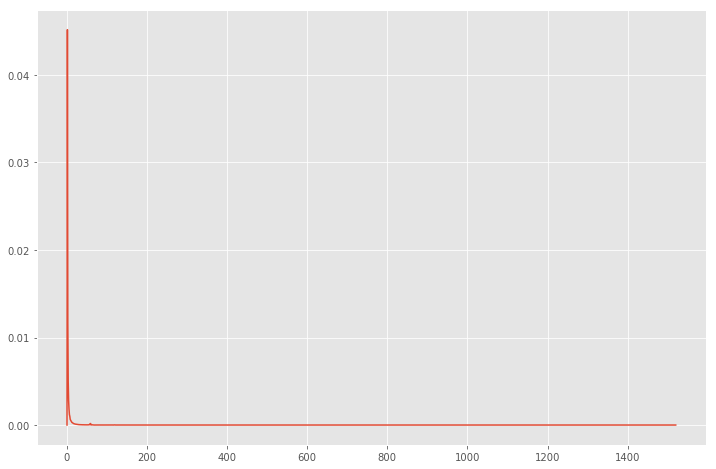

In [97]:
from scipy.signal import periodogram
f, pxx = periodogram(mauna_loa['norm_y'], len(mauna_loa['norm_y']))
fig = plt.figure(figsize=(12, 8))
plt.plot(f, pxx)

In [98]:
max(f)

1520.0

In [99]:
omega_zero = f[np.argmax(pxx)]
unbound_omega_zero = np.log(omega_zero)
omega_zero, unbound_omega_zero

(1.0, 0.0)

In [49]:
alpha_zero = 3 / y_range
unbound_alpha_zero = np.log(alpha_zero)
alpha_zero, unbound_alpha_zero

(0.03088326127239037, -3.477540948249489)

In [90]:
sinuosdial_model = """
data {
    int<lower=0> N; // number of data points
    int<lower=0> N_future; // number of 'future' test set data points
    vector[N] y;      // observed CO2 values
    vector[N] t;      // the days
    vector[N] t_future;      // the days
    real unbound_omega_zero;  // the initial omega
    real unbound_alpha_zero;  // the initial alpha
}

parameters {
    real b_0;    // linear regression intercept
    real b_1;     // linear regression slope
    real<lower=0> sigma_lr; // linear regression residual error

    real unbound_omega; // the frequency parameter, in its unbound form
    real unbound_phi;   // the phase shift parameter, in its unbound form
    real unbound_alpha; // the amplitude frequency in its unbound form
    real<lower=0> sigma_y; // overall prediction residual rror
}

transformed parameters {
    real<lower=0> omega;
    real<lower=0, upper=2 * pi()> phi;
    real<lower=0> alpha;
    
    omega = exp(unbound_omega);
    phi = 2 * pi() * inv_logit(unbound_phi);
    alpha = exp(unbound_alpha);
}

model {
    // Priors
    b_0 ~ normal(0, 0.1);
    b_1 ~ normal(0, 0.1);
    sigma_lr ~ gamma(1, 0.1);
    
    unbound_omega ~ normal(unbound_omega_zero, 3);
    unbound_phi ~ normal(0, 5);
    unbound_alpha ~ normal(unbound_alpha_zero, 3);
    sigma_y ~ gamma(1, 0.1);
    
    for (i in 1:N) {
        y[i] ~ normal(b_0 + b_1 * t[i] + alpha * cos(omega * t[i] + phi), sigma_y);
    }
}

generated quantities {
  real y_future[N_future];
  
  for(i in 1:N_future) {
    y_future[i] = normal_rng(b_0 + b_1 * t_future[i] + alpha * cos(omega * t_future[i] + phi), sigma_y);
  }
}
"""

sm = pystan.StanModel(model_code=sinuosdial_model, model_name='sinusodial_model', verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL sinusodial_model_424bfc407239b46f19b412dac6283dd7 NOW.
INFO:pystan:OS: linux, Python: 3.6.0 |Anaconda custom (64-bit)| (default, Dec 23 2016, 12:22:00) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)], Cython 0.27.3


Compiling /tmp/tmp4mfyt2l_/stanfit4sinusodial_model_424bfc407239b46f19b412dac6283dd7_362873649359595156.pyx because it changed.
[1/1] Cythonizing /tmp/tmp4mfyt2l_/stanfit4sinusodial_model_424bfc407239b46f19b412dac6283dd7_362873649359595156.pyx
building 'stanfit4sinusodial_model_424bfc407239b46f19b412dac6283dd7_362873649359595156' extension
creating /tmp/tmp4mfyt2l_/tmp
creating /tmp/tmp4mfyt2l_/tmp/tmp4mfyt2l_
gcc -pthread -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I/tmp/tmp4mfyt2l_ -I/opt/anaconda3/lib/python3.6/site-packages/pystan -I/opt/anaconda3/lib/python3.6/site-packages/pystan/stan/src -I/opt/anaconda3/lib/python3.6/site-packages/pystan/stan/lib/stan_math -I/opt/anaconda3/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3 -I/opt/anaconda3/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib/boost_1.64.0 -I/opt/anaconda3/lib/python3.6/site-packages/pystan/st

In [91]:
sinusodial_data = {
    'N': len(train),
    'N_future': len(test),
    'y': train['norm_y'],
    't': train['norm_day'],
    't_future': test['norm_day'],
    'unbound_omega_zero': unbound_omega_zero,
    'unbound_alpha_zero': unbound_alpha_zero,
}

fit = sm.sampling(data=sinusodial_data, iter=2000, chains=4, n_jobs=4, 
                  init=lambda: {'b_0': 0, 'b_1': 0.1, 'sigma_lr': 0.05,
                                'unbound_omega': unbound_omega_zero, 'unbound_phi': 0, 
                                'unbound_alpha': unbound_alpha_zero, 'sigma_y': 0.05, 
                               }
                  )

samples = fit.extract()
fit

Inference for Stan model: sinusodial_model_424bfc407239b46f19b412dac6283dd7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b_0            3.0e-3  2.3e-3 3.3e-3-9.9e-4 3.2e-4 1.9e-3 5.0e-3 9.2e-3      2    nan
b_1            2.9e-5  4.2e-7 7.3e-7 2.8e-5 2.9e-5 2.9e-5 3.0e-5 3.0e-5      3    nan
sigma_lr         0.05  2.2e-4 3.2e-4   0.05   0.05   0.05   0.05   0.05      2    nan
unbound_omega -1.3e-3  1.6e-3 2.7e-3-9.2e-3-2.5e-3-3.1e-5 6.9e-4 1.0e-3      3    nan
unbound_phi    1.5e-3  2.8e-3 3.9e-3-3.9e-3-2.6e-3 1.4e-3 5.1e-3 7.6e-3      2   3.76
unbound_alpha   -4.11    0.75   1.31  -6.69  -4.29  -3.66  -3.52  -0.89      3   2.67
sigma_y          0.04  9.1e-3   0.02   0.02   0.03   0.04   0.05   0.12      6   1.41
omega             1.0  1.6e-3 2.7e-3   0.99    1.0    1.0    1.0    1.0      3    nan
phi              3.14  4.3e-3 6

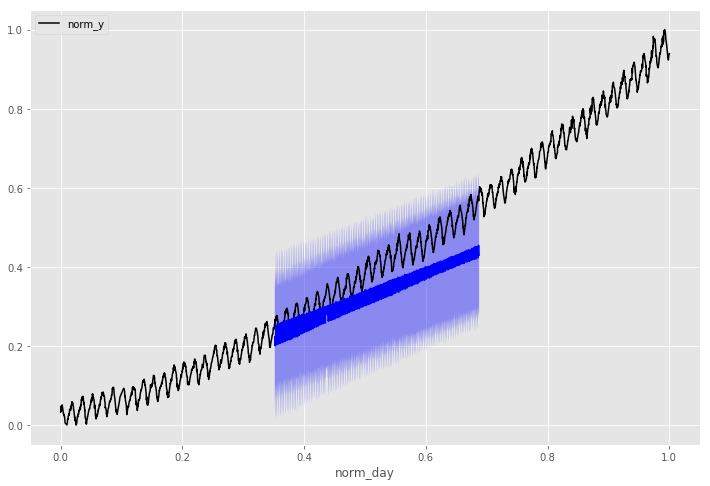

In [93]:
def plot_samples(samples, future=None):
    if future is None:
        future = len(test)
        
    ax = mauna_loa.plot(x='norm_day', y='norm_y', figsize=(12, 8), color='black')
    
    y_future_means = np.mean(samples['y_future'], axis=0)
    y_future_stds = np.std(samples['y_future'], axis=0)
    
    ax.plot(test['norm_day'][:future], y_future_means[:future], color='blue')
    ax.fill_between(test['norm_day'][:future], y_future_means[:future] - 2 * y_future_stds[:future], 
                    y_future_means[:future] + 2 * y_future_stds[:future], alpha=0.4, facecolor='blue')
    
    plt.show()


plot_samples(samples)

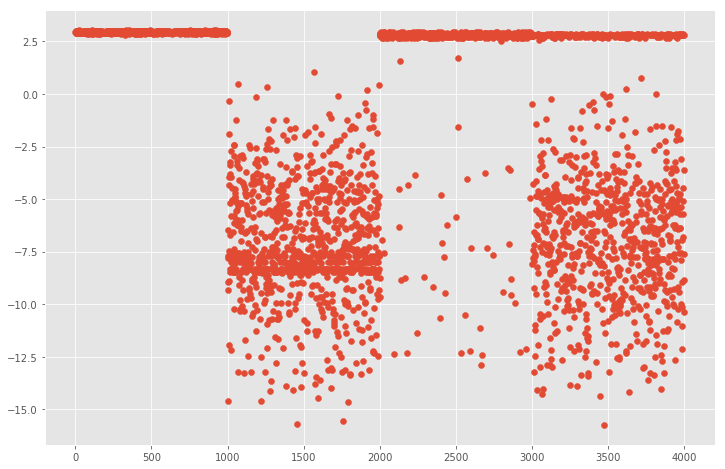

In [77]:
plt.figure(figsize=(12, 8))
plt.scatter(range(samples['unbound_omega'].shape[0]), samples['unbound_omega'])